#TWEET EXTRACTION with roBERTa

In [ ]:
!pip install tensorflow

In [ ]:
pip install transformers[tf-gpu]

In [ ]:
pip install transformers

In [ ]:
pip install sentencepiece

##Nota: 
Reiniciar el entorno de ejecución antes de continuar

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold

In [ ]:
import tokenize

In [ ]:
from transformers import *
import tokenizers
print('TF version',tf.__version__)

TF version 2.6.0


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.distribute.MirroredStrategy

tensorflow.python.distribute.mirrored_strategy.MirroredStrategy

Se clona el repositorio de git para obtener los archivos csv que contienen los datos

In [ ]:
! git clone --recursive https://github.com/Jmazo25/Monografia.git

Cloning into 'Monografia'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


Se leen los datasets de entrenamiento y prueba en formato "csv" para convertirlos a dataframes

In [ ]:
train_df = pd.read_csv("/content/Monografia/train.csv")
test_df = pd.read_csv("/content/Monografia/test.csv")

Se visualiza el dataframe creado a partir de la carga del archivos .csv perteneciente al set de datos de entrenamiento

In [ ]:
train_df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Se visualiza la información relacionada al dataframe cargado:

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Se aprecia el dataframe correspondiente a los datos de test:

In [ ]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


A continuación se valida cuáles columnas del archivo de entrenamiento tienen campos nulos:

In [ ]:
train_df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Se identifica la fila que contiene los datos nulos, la cual corresponde a la etiqueta "Neutral"

In [ ]:
train_df.loc[train_df['text'].isnull()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


A continuación se procede a eliminar la fila nula, para ello se utilizan las funciones:


*   dropna de pandas: con esta función (y los parámetros del código), eliminamos todas las filas en la que hay algún campo que está vacío.
*   reset_index : función de pandas que permite resetear el índice del dataframe.
*   shape: identificamos la cantidad de filas por cantidad de columnas






In [ ]:
# Se eliminarán las filas detectatadas
train_df.dropna(axis = 0, how ='any',inplace=True)
train_df.reset_index(inplace=True)
train_df.shape

(27480, 5)

Se identifican nuevamente la cantidad de nulos, y en efecto, no hay ninguno

In [ ]:
train_df.isnull().sum()

index            0
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

Se realiza el mismo procedimeinto de buscar nulos para los datos de prueba

In [ ]:
test_df.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

A continuación se define una función que permita identificar la cantidad de filas que hay por cada uno de los sentimientos:

In [ ]:
# función que determina la altura de las barras en el gráfico
def barh(ax): # for getting height
    
    for p in ax.patches:
        val = p.get_height() #height of the bar
        x = p.get_x()+ p.get_width()/2 # x- position 
        y = p.get_y() + p.get_height()/2 #y-position
        ax.annotate(round(val,2),(x,y))

Se generará un histograma con la distribución de las categorías existentes en la variable "sentimient", en el dataframe de entrenamiento:

In [ ]:
sb.set_theme()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


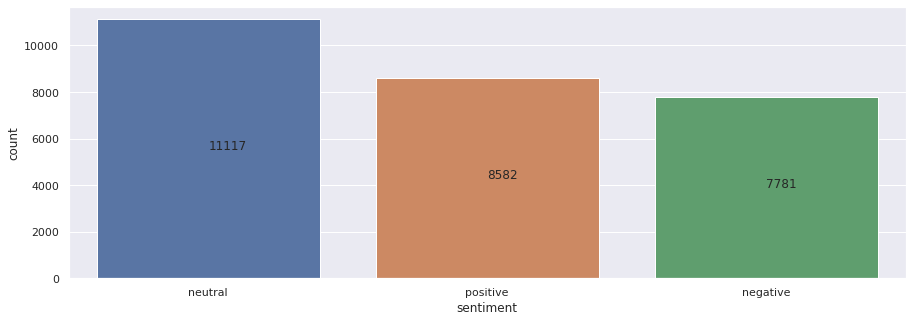

In [ ]:
plt.figure(figsize=(15,5))
ax0 = sb.countplot(train_df['sentiment'],order=train_df['sentiment'].value_counts().index)
barh(ax0)
plt.show()

Subsiguiente se validará la distribución por sentimiento del archivo de prueba:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


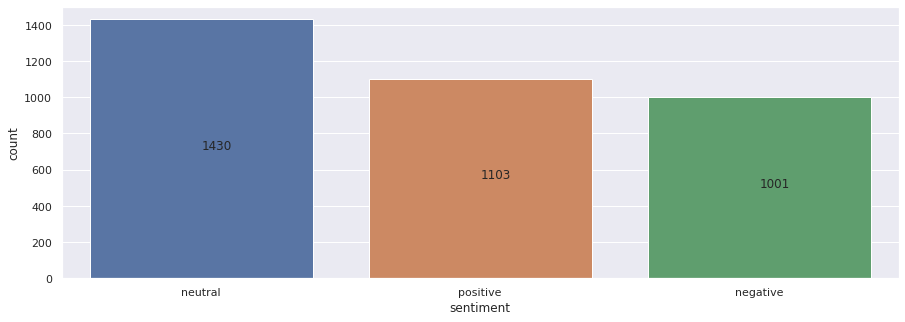

In [ ]:
plt.figure(figsize=(15,5))
ax1 = sb.countplot(test_df['sentiment'],order=test_df['sentiment'].value_counts().index)
barh(ax1)
plt.show()

De acuerdo a la observación anterior, la data tanto de entrenamiento como de prueba tiene distribuciones similares, ya que su mayoría está en los neutrales, seguidos por los positivos, y finalmente los negativos.

Ahora se segmentará el dataset de entrenamiento de acuerdo al sentimiento:

In [ ]:
positive_text = train_df[train_df['sentiment'] == 'positive']['selected_text']
negative_text = train_df[train_df['sentiment'] == 'negative']['selected_text']
neutral_text = train_df[train_df['sentiment'] == 'neutral']['selected_text']

Se definirán dos funciones, la primera que corresponde a la limpieza del campo "text" de caracteeres especiales, url's, etiquetas tipo xml, puntuación, saltos de línea, entre otras condiciones, y la segunda que implementará la función anterior y eliminará "stopwords", correpondientes a prepocisiones y otras palabras que no influyen en la clasificacion del texto

In [ ]:
def clean_text(text):
    
    text = text.lower() #minusculas
    text = re.sub('\[.*?\]', '', text) #caracteres especiales
    text = re.sub('https?://\S+|www\.\S+', '', text)#urls
    text = re.sub('<.*?>+', '', text) #etiquetas
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #puntuación
    text = re.sub('\n', '', text) #saltos de línea
    text = re.sub('\w*\d\w*', '', text) #números entre las palabras
    return text


def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

Se aplican las funciones anteriores a cada uno de las categorías

In [ ]:
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

In [ ]:
positive_text_clean.head(5)

6                                                   fun
9                              wow u just became cooler
11                                                 like
21                                          interesting
25    the free fillin app on my ipod is fun im addicted
Name: selected_text, dtype: object

Con la ayuda de la API Wordcloud para gráficas se destacarán para cada una de las categorías las palabras que mas influyen en la clasificación de dicho sentiemiento.

Fuente: https://www.kaggle.com/deepakat002/tweeter-sentiment-phrase-extraction-roberta

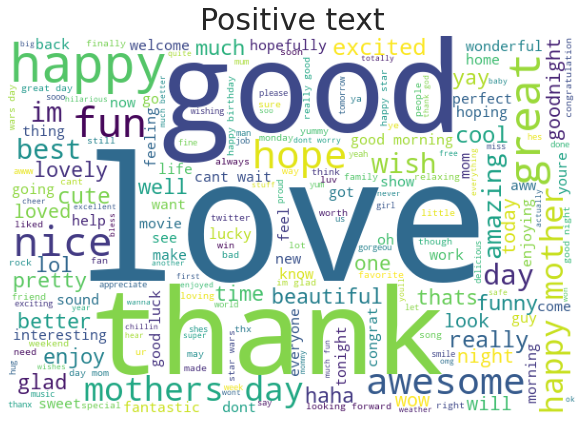

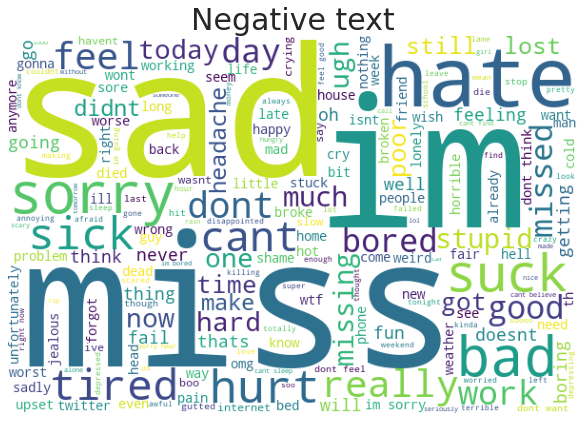

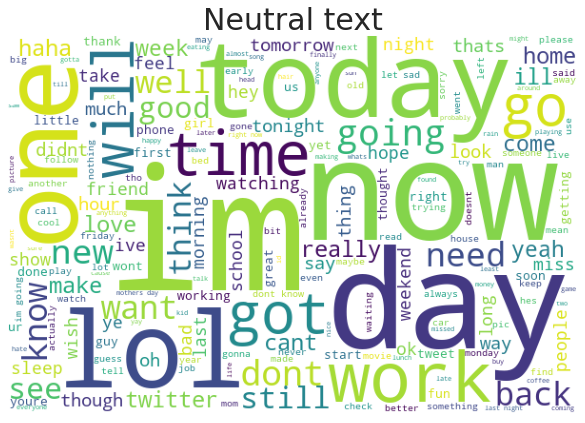

In [ ]:
#importing word cloud

from wordcloud import WordCloud

plt.figure(figsize = (20,7))
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Positive text',fontsize=30);

plt.figure(figsize = (20,7))
wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Negative text',fontsize=30);

plt.figure(figsize = (20,7))
wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
plt.imshow(wordcloud3)
plt.axis('off')
plt.title('Neutral text',fontsize=30);

Posterior a laexploración del DataSet, se decide utilizar el estado del arte roBERTa para crear el modelo

Para ello se deberá crear una entrada adecuada para el modelo a utilizar

Se utiliza el proyecto Tokenizer que es de los más utilizados en el momento para este fin, al elegir el estado del arte roBERTa para el modelo debemos codificar las sentencias de modo que la entrada sea la esperada por el modelo, por lo cual empleamos los archivos vocab y merge adecuados para la base de roberta.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Según la documentación de transformers para robERTa se utiliza un atributo del  módulo "tokenizer" llamado "ByteLevelBPETokenizer" ó RobertaTokenizer, en este caso utilizaremos el primero.

fuente: "https://huggingface.co/transformers/model_doc/roberta.html"

In [ ]:
PATH = '/content/drive/MyDrive/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab=PATH + 'vocab-roberta-base.json', 
    merges=PATH + 'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

Observamos como asocia los IDS y los tokens a una sentencia aleatoria \
fuente: "https://pypi.org/project/tokenizers/"

In [ ]:
encoded = tokenizer.encode("I can feel the magic, can you?")
print(encoded.ids)
print(encoded.tokens)

[939, 64, 619, 5, 8375, 6, 64, 47, 116]
['Ġi', 'Ġcan', 'Ġfeel', 'Ġthe', 'Ġmagic', ',', 'Ġcan', 'Ġyou', '?']


Se calcula el tamaño máximo de un tweet en la columna 'text' de la data de entrenamiento, esto para una de las dimensiones del tensor

In [ ]:
MAX_LEN = 0

for text in train_df['text']:

    # Se tokeniza el texto y se le añaden  i.e [`<s>]` and `[SEP]`
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # sólo actualiza el valor máximo de la sentencia
    MAX_LEN = max(MAX_LEN, len(input_ids))


print('longitud máxima del tweet: ', MAX_LEN)

longitud máxima del tweet:  100


Simplemente se va a conocer los IDS para cada uno de las 3 categorías en las cuales vamos a clasificar los tweets: Positivo, neutral y negativo

In [ ]:
sent = ['positive','negative','neutral']
sent_id =[]
for i in sent:
    sent_id.append(tokenizer.encode(i).ids[0])
sentiment_id = dict(zip(sent,sent_id))
sentiment_id

{'negative': 2430, 'neutral': 7974, 'positive': 1313}

Con la ilustración de un trozo de código extraído de la página Kaggel.com sobre el formato de entrada de los tweets al modelo de roBERTa, se transforman ambos dataset para obtener la entrada esperada del modelo

fuente: https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705

Dataset de entrenamiento

In [ ]:
#creating RoBERTa format inputs (input_ids,attention_mark,start_tokens,end_tokens)

ct = train_df.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train_df.shape[0]):
    
    # Finding overlap between text and selected_text
    text1 = " "+" ".join(train_df.loc[k,'text'].split())
    #print(text1)
    text2 = " ".join(train_df.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
        chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
    #print(enc)
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START & END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train_df.loc[k,'sentiment']]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

Dataset de pruebas

In [ ]:
ct = test_df.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(test_df.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test_df.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test_df.loc[k,'sentiment']]
    input_ids_t[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc.ids)+5] = 1

Fuente https://huggingface.co/transformers/model_doc/roberta.html

La generación del modelo funcional que se observa a continuación se realiza con ayuda de la API para Deep Learning "Keras" la cual se ejecuta sobre el framework de TensorFlow, se aprecia además la implementación de un modelo preentrenado (Embbeding, característica de roBERTa) instanciandolo de la clase TFRobertaModel para luego ingresarlo como entrada a la arquitectura de red definida

In [ ]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    #we have to target variables (start_token and end_token). hence we are creating two models to classify values(1 or 0) for these variables
    
    '''
    The Conv1D are essential because they preserve spatial information. We want our model to predict a start index and end index which are spatial.
    If you use GlobalAveragePooling1D you will lose spatial information. You will know which texts are positive, negative, neutral but you won't 
    know where the words are located.
    '''
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [ ]:
model2 = build_model()

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
from tensorflow.keras.utils import plot_model

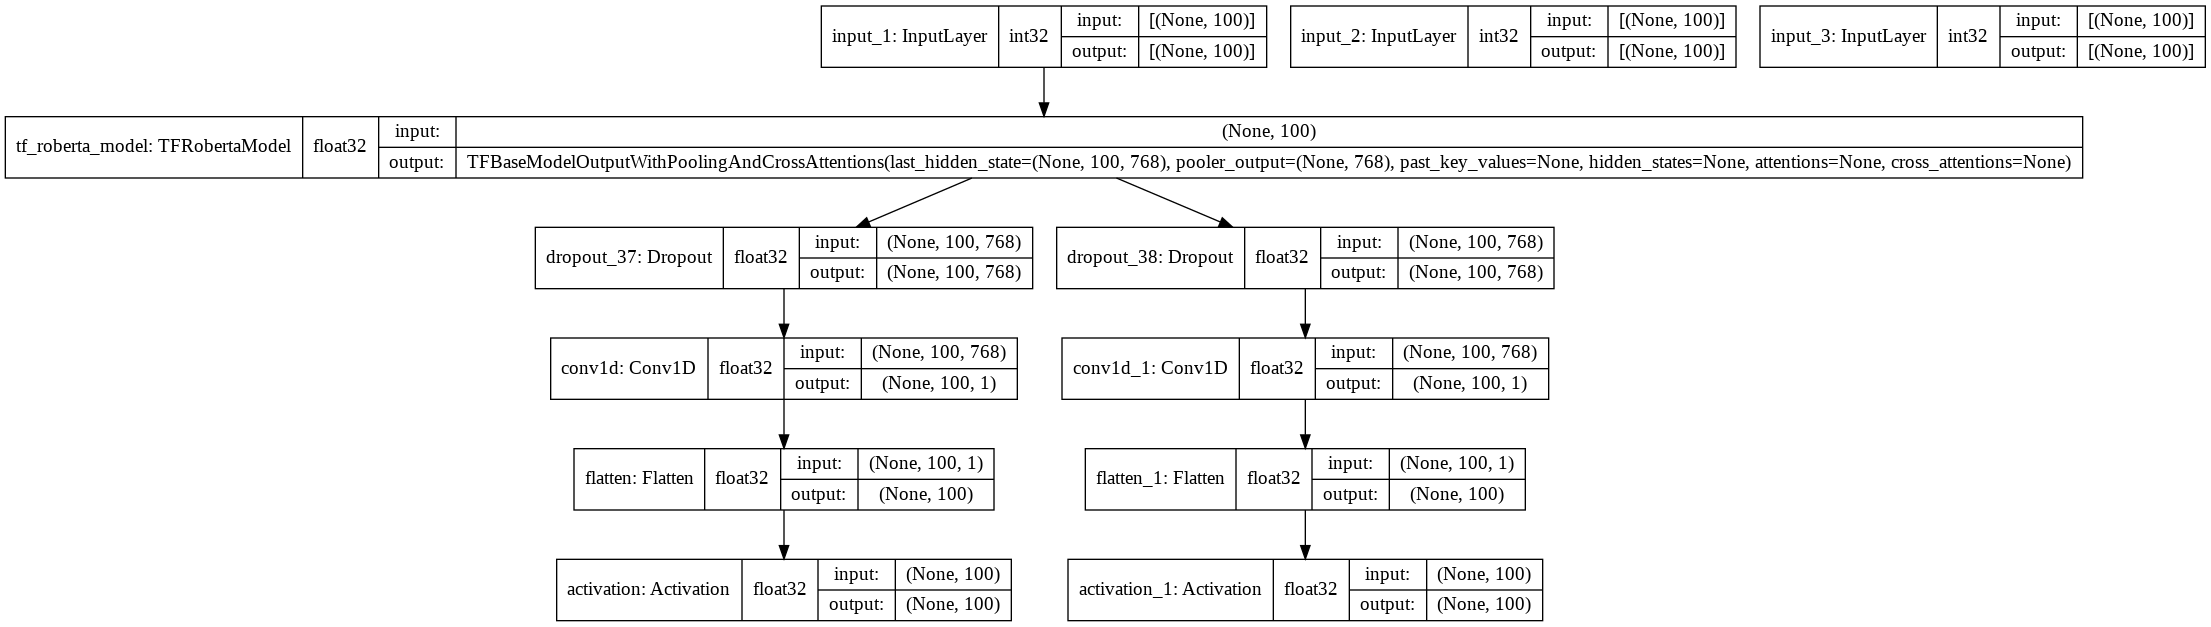

In [ ]:
plot_model(model2, "roBERTa.png",show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96,
    layer_range=None)

Ya se tokenizaron ambos dataset, tanto el de entrenamiento como el de prueba, se convirtieron al formato que requiere nuestro modelo para que sea procesado de forma adecuada, con los tokens de inicio y de final de sentencia y otros requeridos, el modelo fue construido con base a código tanto de los colaboradores del reto como de la documentación oficial

Ahora bien como la métrica es la función de Jaccard para encontrar la similitud de dos conjuntos, se va definir la función de python tal cual fue proveída en el reto

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

El modelo ya se encuentra entrenado en el Notebook "01 -train_Proyecto_tweet_extraction" por lo cual en este punto no se entrenará dicho modelo, sino que se cargarán los pesos previamente generados y se realizará la predicción

In [ ]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train_df.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch') #to save best weights 
        
    #model.fit([input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        #epochs=5, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        #validation_data=([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]], 
        #[start_tokens[idxV,], end_tokens[idxV,]])) 
    
    print('Loading model...')
    model.load_weights(PATH + "v0-roberta-1.h5")
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,],token_type_ids[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t,token_type_ids_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train_df.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train_df.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,train_df.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading model...
Predicting OOF...
172/172 [==============================] - 70s 386ms/step
Predicting Test...
111/111 [==============================] - 43s 386ms/step
>>>> FOLD 2 Jaccard = 0.7036699840482631

#########################
### FOLD 3
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading model...
Predicting OOF...
172/172 [==============================] - 70s 385ms/step
Predicting Test...
111/111 [==============================] - 43s 385ms/step
>>>> FOLD 3 Jaccard = 0.7412694777387938

#########################
### FOLD 4
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading model...
Predicting OOF...
172/172 [==============================] - 69s 385ms/step
Predicting Test...
111/111 [==============================] - 43s 385ms/step
>>>> FOLD 4 Jaccard = 0.7474392641475543

#########################
### FOLD 5
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/MyDrive/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading model...
Predicting OOF...
172/172 [==============================] - 70s 385ms/step
Predicting Test...
111/111 [==============================] - 43s 385ms/step
>>>> FOLD 5 Jaccard = 0.7496126028053327



In [ ]:
type(preds_start)

numpy.ndarray

In [ ]:
preds_start

array([[8.26602289e-07, 9.99671221e-01, 4.36155415e-05, ...,
        3.41426221e-08, 3.41426221e-08, 3.41426221e-08],
       [5.06488220e-06, 2.50425581e-01, 2.37771474e-04, ...,
        2.58708366e-08, 2.58708366e-08, 2.58708366e-08],
       [2.91600855e-06, 3.74149159e-02, 4.50847219e-04, ...,
        2.58148969e-08, 2.58148969e-08, 2.58148969e-08],
       ...,
       [1.07048902e-05, 9.74598061e-02, 2.32155202e-03, ...,
        5.66925973e-08, 5.66924907e-08, 5.66925440e-08],
       [2.20186280e-06, 8.09501274e-03, 2.52351083e-05, ...,
        1.11764964e-08, 1.11764964e-08, 1.11765175e-08],
       [4.49565277e-06, 3.35610064e-03, 1.59278056e-05, ...,
        4.67722705e-08, 4.67722305e-08, 4.67723194e-08]])

In [ ]:
np.argmax(preds_end[45,]), np.argmax(preds_start[45,])

(5, 1)

In [ ]:
preds_start[45]

array([5.11490157e-06, 5.28248623e-01, 1.35305617e-02, 2.10718508e-02,
       4.57899552e-02, 3.88984010e-01, 1.54968420e-04, 1.64408775e-04,
       2.04296695e-03, 1.34311549e-07, 2.80681256e-07, 3.19754534e-07,
       1.56668012e-07, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
       7.73482078e-08, 7.73482078e-08, 7.73482078e-08, 7.73482078e-08,
      

Para este apartado ya se tiene una predicción con las listas preds_start y preds_end(memoria espacial), según el valor recorrido en ambas listas se determina el texto seleccionado con las reglas observadas en la celda a continuación, es importante tener en cuenta que el objetivo principal es guardar las ubicaciones espaciales del texto para comprobar que efectivamente pertenecen al sentimiento etiquetado

In [ ]:
result= []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test_df.loc[k,'text']
    else:
        text1 = " "+" ".join(test_df.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    result.append(st)
result[:5]

[' last session of the day http://twitpic.com/67ezh',
 ' exciting',
 ' such a shame!',
 ' happy bday!',
 ' i like it!!']

En este caso se convierte la variable "result" en la columna texto seleccionado y se finaliza el reto con el archivo final .csv el cual se exige como entrega

In [ ]:
test_df['selected_text'] = result
test_df[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.read_csv('submission.csv').head(10)

,textID,selected_text
0,f87dea47db,last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,such a shame!
3,01082688c6,happy bday!
4,33987a8ee5,i like it!!
5,726e501993,that`s great!!
6,261932614e,hates
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,what did you get? my day is alright.. haven`t...
